In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.style.use('ggplot')

In [2]:
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
feature_types = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 
                 'rmse', 'spectral_centroid', 'spectral_bandwidth', 
                 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']

In [4]:
to_concat = tracks, features
#print(type(tracks), type(features))
df_test = pd.concat(to_concat, axis=1)

df_test = df_test.drop(columns='album', axis=1)
df_test = df_test.drop(columns='artist', axis=1)
df_test = df_test.drop(columns=('track', 'bit_rate'), axis=1)
df_test = df_test.drop(columns=('track', 'comments'), axis=1)
df_test = df_test.drop(columns=('track', 'composer'), axis=1)
df_test = df_test.drop(columns=('track', 'date_created'), axis=1)
df_test = df_test.drop(columns=('track', 'date_recorded'), axis=1)
df_test = df_test.drop(columns=('track', 'duration'), axis=1)
df_test = df_test.drop(columns=('track', 'favorites'), axis=1)
df_test = df_test.drop(columns=('track', 'genres'), axis=1)
df_test = df_test.drop(columns=('track', 'genres_all'), axis=1)
df_test = df_test.drop(columns=('track', 'information'), axis=1)
df_test = df_test.drop(columns=('track', 'interest'), axis=1)
df_test = df_test.drop(columns=('track', 'language_code'), axis=1)
df_test = df_test.drop(columns=('track', 'license'), axis=1)
df_test = df_test.drop(columns=('track', 'listens'), axis=1)
df_test = df_test.drop(columns=('track', 'lyricist'), axis=1)
df_test = df_test.drop(columns=('track', 'number'), axis=1)
df_test = df_test.drop(columns=('track', 'publisher'), axis=1)
df_test = df_test.drop(columns=('track', 'tags'), axis=1)
df_test = df_test.drop(columns=('track', 'title'), axis=1)
df_test = df_test.drop(columns=('set', 'split'), axis=1)

#print(type(df_test['chroma_cens', 'kurtosis', '1']))

small = tracks['set', 'subset'] <= 'small'
#df_test = df_test.loc[small]

#df_test = df_test.drop(columns=('set', 'subset'), axis=1)

df_test.head()

set     track chroma_cens                                \
          subset genre_top    kurtosis  kurtosis  kurtosis  kurtosis   
track_id                                                               
2          small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3         medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5          small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10         small       Pop    3.702245 -0.291193  2.196742 -0.234449   
20         large       NaN   -0.193837 -0.198527  0.201546  0.258556   

                                                  ...   tonnetz            \
          kurtosis  kurtosis  kurtosis  kurtosis  ...       std       std   
track_id                                          ...                       
2         1.482478  0.531371  1.481593  2.691455  ...  0.054125  0.012226   
3         1.654031  0.067592  1.366848  1.054094  ...  0.063831  0.014212   
5         1.937570  0.880839 -0.923192 -0.927232  ...  0.040730  0.012691   
10        1.367364  0.998411  1.770694  1.604566  ...  0.074358  0.017952   
20        0.775204  0.084794 -0.289294 -0.816410  ...  0.095003  0.022492   

                          zcr                                          \
               std   kurtosis       max      mean    median       min   
track_id                                                                
2         0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3         0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5         0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10        0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20        0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

                              
              skew       std  
track_id                      
2         2.089872  0.061448  
3         1.716724  0.069330  
5         2.193303  0.044861  
10        3.542325  0.040800  
20        3.189831  0.030993  

[5 rows x 520 columns]

In [5]:
# ONLY RUN THIS ONCE

df_colated = df_test
df_colated.columns = ['-'.join(col).strip() for col in df_colated.columns.values]
df_colated.head()

,set-subset,track-genre_top,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,...,tonnetz-std,tonnetz-std,tonnetz-std,zcr-kurtosis,zcr-max,zcr-mean,zcr-median,zcr-min,zcr-skew,zcr-std
track_id,,,,,,,,,,,,,,,,,,,,,
2,small,Hip-Hop,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,medium,Hip-Hop,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,small,Hip-Hop,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,small,Pop,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,large,NaN,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [6]:
label_encoder = sklearn.preprocessing.LabelEncoder()
df_labenc = df_test
df_labenc['track-genre_top'] = label_encoder.fit_transform(df_test['track-genre_top'])
df_labenc['track-genre_top'].value_counts()
df_labenc.head()

,set-subset,track-genre_top,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,...,tonnetz-std,tonnetz-std,tonnetz-std,zcr-kurtosis,zcr-max,zcr-mean,zcr-median,zcr-min,zcr-skew,zcr-std
track_id,,,,,,,,,,,,,,,,,,,,,
2,small,7,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,medium,7,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,small,7,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,small,12,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,large,16,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [7]:
df_labenc.corr()

,track-genre_top,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,chroma_cens-kurtosis,...,tonnetz-std,tonnetz-std,tonnetz-std,zcr-kurtosis,zcr-max,zcr-mean,zcr-median,zcr-min,zcr-skew,zcr-std
track-genre_top,1.000000,0.004991,0.002720,0.003370,0.005490,0.006241,0.007274,0.003424,0.004594,0.004494,...,0.054907,0.023075,0.011785,0.004868,-0.029028,-0.035756,-0.014457,0.004826,0.014397,-0.059349
chroma_cens-kurtosis,0.004991,1.000000,0.168040,0.072936,0.114748,0.087447,0.055913,0.093210,0.046958,0.062980,...,-0.021042,-0.016246,-0.011776,0.059554,-0.005076,-0.001692,0.001103,0.006344,0.025801,-0.009808
chroma_cens-kurtosis,0.002720,0.168040,1.000000,0.256776,0.581978,0.563089,0.374696,0.670683,0.249413,0.277566,...,-0.047317,-0.038900,-0.033791,0.027766,-0.013090,-0.001086,0.003289,0.004314,0.016010,-0.011634
chroma_cens-kurtosis,0.003370,0.072936,0.256776,1.000000,0.696866,0.243232,0.159603,0.208861,0.093052,0.126101,...,-0.046026,-0.030043,-0.031115,0.034867,-0.015023,-0.005155,0.000021,0.000966,0.019725,-0.016049
chroma_cens-kurtosis,0.005490,0.114748,0.581978,0.696866,1.000000,0.590232,0.412467,0.549015,0.193489,0.183819,...,-0.028608,-0.021130,-0.019762,0.013741,-0.012290,-0.000912,0.002799,0.000096,0.003503,-0.008062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zcr-mean,-0.035756,-0.001692,-0.001086,-0.005155,-0.000912,-0.004149,-0.000639,-0.000600,-0.001312,0.006950,...,-0.267163,-0.295029,-0.272125,-0.192219,0.302725,1.000000,0.939181,0.269567,-0.355198,0.630817
zcr-median,-0.014457,0.001103,0.003289,0.000021,0.002799,0.000900,0.005873,0.004010,0.004069,0.015165,...,-0.263548,-0.297247,-0.280942,-0.161773,0.151493,0.939181,1.000000,0.308131,-0.353421,0.383143
zcr-min,0.004826,0.006344,0.004314,0.000966,0.000096,-0.000729,-0.000198,0.000075,-0.000354,0.005019,...,-0.061446,-0.098449,-0.100751,0.009136,-0.015115,0.269567,0.308131,1.000000,-0.020148,-0.026719
zcr-skew,0.014397,0.025801,0.016010,0.019725,0.003503,0.048093,0.012586,0.017420,0.023715,0.030556,...,0.181227,0.215362,0.203798,0.785132,0.435548,-0.355198,-0.353421,-0.020148,1.000000,-0.035560


<AxesSubplot:>

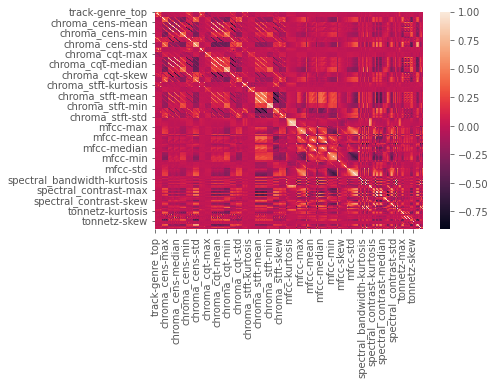

In [8]:
sns.heatmap(df_labenc.corr())

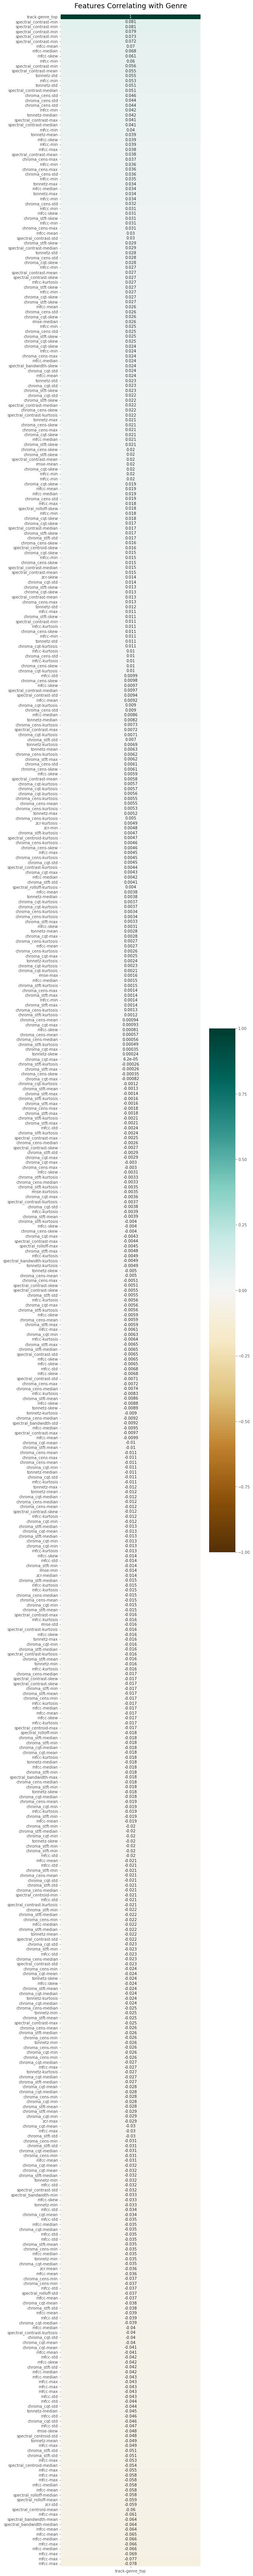

In [9]:
plt.figure(figsize=(8, 120))
heatmap = sns.heatmap(df_labenc.corr()[['track-genre_top']].sort_values(by='track-genre_top', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Genre', fontdict={'fontsize':18}, pad=16);

In [ ]:
# lets use some low level pca to reduce 519 a little
    # chroma_cens - kurtosis, max, mean, median, min, skew, std
    # chroma_cqt - kurtosis, max, mean, median, min, skew, std
    # chroma_stft - kurtosis, max, mean, median, min, skew, std
    # mfcc - kurtosis, max, mean, median, min, skew, std
    # rmse - kurtosis, max, mean, median, min, skew, std (1s)
    # spectral_bandwidth - kurtosis, max, mean, median, min, skew, std (1s)
    # spectral_centroid - kurtosis, max, mean, median, min, skew, std (1s)
    # spectral_contrast - kurtosis, max, mean, median, min, skew, std
    # spectral_rolloff - kurtosis, max, mean, median, min, skew, std (1s)
    # tonnetz - kurtosis, max, mean, median, min, skew, std
    # zcr - kurtosis, max, mean, median, min, skew, std (1s)
    
# need to pcr:
# ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 
# 'spectral_contrast','tonnetz']
# subsets: 
# ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']

In [ ]:
feature_types = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']
to_pcr = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'spectral_contrast','tonnetz']
sound_features = ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']

to_df = {}
genres_list = skl.preprocessing.LabelEncoder().fit_transform(tracks.loc[small, ('track', 'genre_top')])

to_df['genre_top'] = genres_list.tolist()
# print(to_df)

for a in feature_types:
    x = features.loc[small, a]
    x = skl.decomposition.PCA(n_components=1).fit_transform(x)
    
    x_floats = [float(item) for item in x.tolist()]
    
    print(type(x))
    to_df[a] = x_floats.tolist()
    
print(x)
    
print(type(to_df))

final_df = pd.DataFrame(to_df)
print(type(final_df['chroma_cens'][0]))
final_df.head()

In [12]:
# 518 features rn
pca_518 = skl.decomposition.PCA(n_components=518, random_state=2020)

x_ = features.loc[small]
X = x_.values
X.shape

# scaling
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [13]:
pca_518.fit(scaled_X)
X_pca_518 = pca_518.transform(scaled_X)

In [14]:
print("Variance explained by all components: ", sum(pca_518.explained_variance_ratio_*100))
np.cumsum(pca_518.explained_variance_ratio_*100)

Variance explained by all components:  100.00000000000004


array([ 11.8109433 ,  19.3463302 ,  23.89086787,  26.99821306,
        29.81887456,  32.60486696,  35.10360793,  37.59720217,
        39.88695694,  41.87074438,  43.68481752,  45.32045424,
        46.88981459,  48.41369595,  49.76704495,  50.95379561,
        52.07862276,  53.16794212,  54.20156541,  55.16400307,
        56.09591559,  56.95538948,  57.75639307,  58.51778655,
        59.25798344,  59.94454648,  60.61905994,  61.27499252,
        61.90322709,  62.49341906,  63.05228302,  63.60722739,
        64.13646492,  64.64704647,  65.14609134,  65.63026782,
        66.10454629,  66.57290311,  67.02355839,  67.46526381,
        67.89649811,  68.32370646,  68.73366297,  69.13921271,
        69.52813844,  69.91135679,  70.28156725,  70.6447648 ,
        71.0006082 ,  71.35114933,  71.6980794 ,  72.04318915,
        72.37766814,  72.70088273,  73.01438413,  73.32475554,
        73.63340581,  73.93482703,  74.23211938,  74.52377783,
        74.8135268 ,  75.09966651,  75.38272877,  75.66

Text(0, 0.5, 'explained variance (%)')

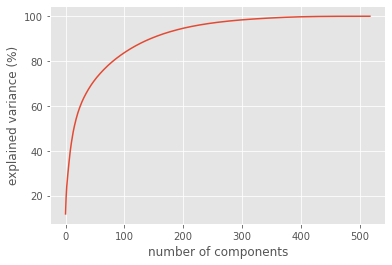

In [15]:
plt.plot(np.cumsum(pca_518.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('explained variance (%)')

In [16]:
print("variance for first principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[0])

print("variance for second principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[1])

print("variance for third principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[2])

print("variance for tenth principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[9])

print("variance for fiftieth principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[49])

print("variance for one hundredth principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[99])

print("variance for one hundred fiftieth principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[149])

print("variance for two hundredth principle component:", 
      np.cumsum(pca_518.explained_variance_ratio_*100)[199])

variance for first principle component: 11.810943297161138
variance for second principle component: 19.34633020471753
variance for third principle component: 23.890867869315326
variance for tenth principle component: 41.870744381386295
variance for fiftieth principle component: 71.35114933310288
variance for one hundredth principle component: 83.60373763508454
variance for one hundred fiftieth principle component: 90.50365370484278
variance for two hundredth principle component: 94.58872502328121


In [17]:
pca_95 = skl.decomposition.PCA(n_components=0.95, random_state=2020)
pca_95.fit(scaled_X)
scaled_X95 = pca_95.transform(scaled_X)

scaled_X95.shape

(8000, 207)

Text(0, 0.5, 'transformed data')

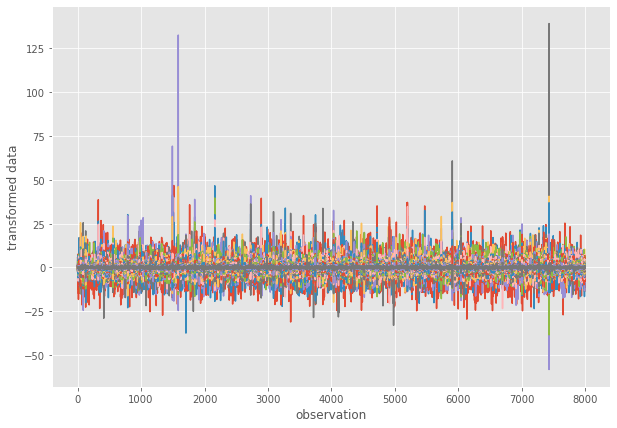

In [19]:
plt.figure(figsize=(10,7))
plt.plot(scaled_X95)
plt.xlabel('observation')
plt.ylabel('transformed data')

In [21]:
df_new = pd.DataFrame(scaled_X95)

#sub_tracks = df_test['track', 'genre_top']

X5 = pd.DataFrame(tracks.loc[small, ('track', 'genre_top')])

X5['track_id'] = X5.index
X5.index = range(len(X5))

df_new['track_id'] = X5['track_id'].astype(int)
df_new['genre'] = X5['track', 'genre_top']
df_new = df_new.set_index('track_id')
# df_new['genre'] = tracks.loc[small, ('track', 'genre_top')]


df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,genre
track_id,,,,,,,,,,,,,,,,,,,,,
2,3.766384,-1.519412,5.559855,4.246582,-1.264305,2.937378,-6.901155,3.566833,5.423144,-0.642307,...,0.898656,0.977823,0.059806,-0.288914,0.363104,0.520921,0.164981,-0.113590,-0.215185,Hip-Hop
5,2.546645,-2.810677,3.151781,-1.564994,1.559586,0.893825,-4.233501,-0.136081,1.178184,0.493892,...,0.133675,0.266687,-0.598550,-0.098018,-0.449447,0.434844,-0.101114,-1.169093,-0.132089,Hip-Hop
10,7.481670,3.418413,4.218308,-1.776755,0.160894,1.073259,-4.609357,-4.353721,-0.203244,-0.051325,...,-0.181694,0.089688,-0.433400,0.200464,0.167070,-0.702380,0.204836,0.211487,-0.671432,Pop
140,-3.910283,-3.698977,-2.029509,-2.115085,2.760710,-4.163096,2.617659,-0.627254,0.173277,-1.145084,...,0.014981,-0.090075,-0.348454,0.000227,0.234941,-0.336151,0.066578,-0.236800,-0.091404,Folk
141,-8.391543,-0.211722,-0.111673,-3.103520,-0.973389,-2.811022,2.718814,1.188717,-2.889988,-0.255277,...,0.010913,-0.153766,-0.388546,-0.020001,-0.594932,-0.193472,-0.061834,0.271605,0.179913,Folk


In [ ]:
df_new['genre'].value_counts()

small_fr = df_new['genre'] <=

In [22]:
label_encoder = sklearn.preprocessing.LabelEncoder()
df_labenc = df_new
df_labenc['genre'] = label_encoder.fit_transform(df_new['genre'])
df_labenc['genre'].value_counts()
df_labenc.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,genre
track_id,,,,,,,,,,,,,,,,,,,,,
2,3.766384,-1.519412,5.559855,4.246582,-1.264305,2.937378,-6.901155,3.566833,5.423144,-0.642307,...,0.898656,0.977823,0.059806,-0.288914,0.363104,0.520921,0.164981,-0.113590,-0.215185,3
5,2.546645,-2.810677,3.151781,-1.564994,1.559586,0.893825,-4.233501,-0.136081,1.178184,0.493892,...,0.133675,0.266687,-0.598550,-0.098018,-0.449447,0.434844,-0.101114,-1.169093,-0.132089,3
10,7.481670,3.418413,4.218308,-1.776755,0.160894,1.073259,-4.609357,-4.353721,-0.203244,-0.051325,...,-0.181694,0.089688,-0.433400,0.200464,0.167070,-0.702380,0.204836,0.211487,-0.671432,6
140,-3.910283,-3.698977,-2.029509,-2.115085,2.760710,-4.163096,2.617659,-0.627254,0.173277,-1.145084,...,0.014981,-0.090075,-0.348454,0.000227,0.234941,-0.336151,0.066578,-0.236800,-0.091404,2
141,-8.391543,-0.211722,-0.111673,-3.103520,-0.973389,-2.811022,2.718814,1.188717,-2.889988,-0.255277,...,0.010913,-0.153766,-0.388546,-0.020001,-0.594932,-0.193472,-0.061834,0.271605,0.179913,2


In [24]:
df_labenc.to_csv('pca95_data.csv')